# Notebook for performing evaluation on the search engine results

## Running the below code blocks will require up to 6GB of free RAM for the word encodings

In [1]:
# Imports
import gensim.downloader as api
import numpy as np
import search_engine as se
from nltk.tokenize import word_tokenize
import nltk.translate.bleu_score as bleu_score
from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
# Resource setup
sfunction = bleu_score.SmoothingFunction()

print("Loading word encodings...")
w2v = api.load("word2vec-google-news-300")

# Initialize the search engine class
print("Initializing search engine(s)...")
coco_clip = se.SearchEngine('coco_dataset')
# unsplash_clip = se.SearchEngine('unsplash_dataset')

print("Setup completed")

Loading word encodings...
Initializing search engine(s)...
Setup completed


In [3]:
with open("eval_data/queries.json") as query_file:
    query_categories = json.load(query_file)


In [4]:
cat_count = 7                               # Total number of categories
cat_queries = 10                            # Number of queries per categories
image_count = 50                            # Number of images per query
image_dist = 20                             # Distance between image for broader sampling spectrum

bleu_scores = np.zeros((cat_count, cat_queries, image_count))  # Bleu-scores
wmd_scores  = np.zeros((cat_count, cat_queries, image_count))   # Word mover distance scores based on w2v
cos_scores  = np.zeros((cat_count, cat_queries, image_count))   # Cosine scores based on w2v+scipy

model_words = w2v.index_to_key

# Convert the queries to the corresponding indices from word2wec
def query_to_indices(query):
    idx_query = np.zeros(300)
    for word in query:
        lword = word.lower()
        uword = word.upper()
        if lword in model_words:
            idx_query += w2v[lword]
        elif uword in model_words:
            idx_query += w2v[uword]
    return idx_query

# Calculate the relevance for all images for all queries
for ci, category in enumerate(query_categories.keys()):
    for qi, query in tqdm(enumerate(query_categories[category])):
        indices = [i*image_dist for i in list(range(image_count))]
        descriptions = coco_clip.search(query, image_count*image_dist, return_url=False)
        filtered_descriptions = [descriptions[i] for i in indices]
        s_query = word_tokenize(query)

        # Calculate the similarity between the query and engine result for all measures
        for di, description in enumerate(filtered_descriptions):
            s_description = word_tokenize(description)
            bleu_scores[ci][qi][di] = bleu_score.sentence_bleu([s_query], s_description, smoothing_function=sfunction.method4)
            wmd_scores[ci][qi][di] = w2v.wmdistance(s_query, s_description)
            cos_scores[ci][qi][di] = spatial.distance.cosine(query_to_indices(s_query), query_to_indices(s_description))


10it [01:19,  7.97s/it]
10it [01:26,  8.68s/it]
10it [01:17,  7.74s/it]
10it [01:18,  7.80s/it]
10it [01:22,  8.20s/it]
10it [01:18,  7.88s/it]
10it [01:13,  7.34s/it]


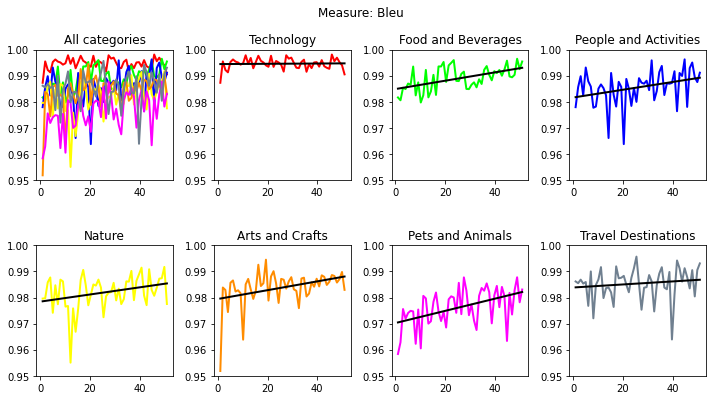

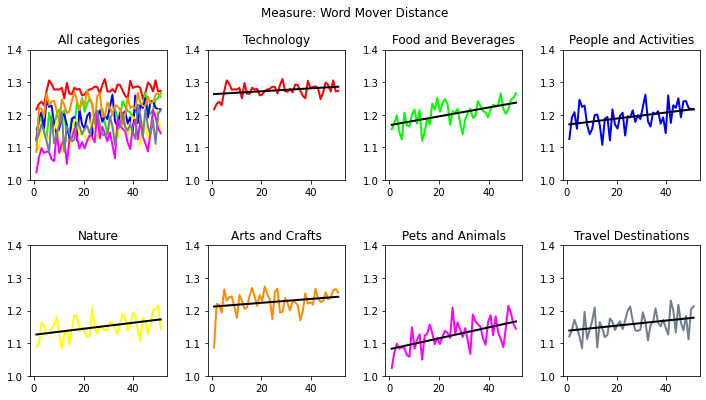

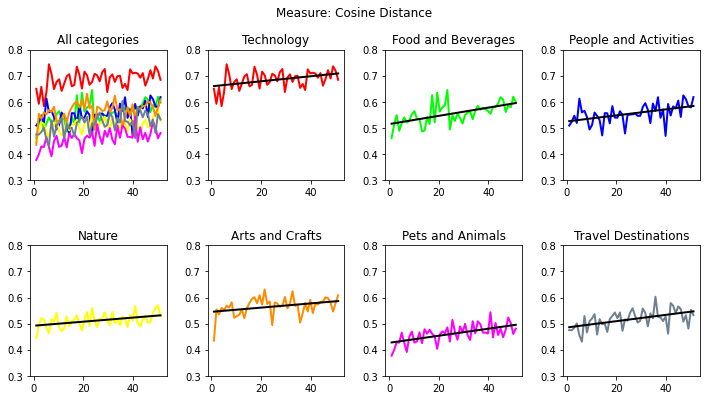

In [7]:
# Plotting of the results
color_list = ["red", "lime", "blue", "yellow", "darkorange", "magenta", "slategray"]
category_list = ["Technology", "Food and Beverages", "People and Activities", "Nature", "Arts and Crafts", "Pets and Animals", "Travel Destinations"]
measures = {"Bleu": bleu_scores, "Word Mover Distance": wmd_scores, "Cosine Distance": cos_scores}
y_limits = [[0.95, 1], [1, 1.4], [0.3, 0.8]]

x = np.linspace(1, 51, 50)

# Correct measurements in case of Bleu, since those results are reversed
for mi, (name, measure) in enumerate(measures.items()):
    if name == "Bleu":
        average_ranks = np.subtract(1, np.average(measure, axis=1))
    else:
        average_ranks = np.average(measure, axis=1)

    # Create the base plot
    fig, axs = plt.subplots(2, 4)
    fig.set_size_inches(12, 6)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle(f"Measure: {name}")
    axs[0][0].set_ylim(y_limits[mi])
    axs[0][0].set_title(f"All categories")

    for i in list(range(7)):
        # Calculate Trend line
        fit = np.polyfit(x, average_ranks[i], 1)
        trend = np.poly1d(fit)

        # Create all relevant data for the plots
        axs[0][0].plot(x, average_ranks[i], linewidth=2, color=color_list[i])
        axs[(i+1) // 4][(i+1) % 4].plot(x, average_ranks[i], linewidth=2, color=color_list[i])
        axs[(i+1) // 4][(i+1) % 4].plot(x, trend(x), linewidth=2, color="black")
        axs[(i+1) // 4][(i+1) % 4].set_title(f"{category_list[i]}")
        axs[(i+1) // 4][(i+1) % 4].set_ylim(y_limits[mi])
    plt.show()